# Machine Learning을 통한 환율 예측
<br><br>

 ## (1) 서론
 <br>
 환율은 주식의 가격과 마찬가지로, 경제, 정치, 사회 등 다양한 요인에 의해 끊임없이 변화한다.<br>
 다른 국가의 돈으로 환전을 할 때, 이렇게 변화하는 환율을 예측할 수 있다면 더 좋은 조건에서 환전할 수 있어 편리할 것이다.<br>
 <br>
 그렇다면, 이러한 환율의 변화를 머신러닝을 통해 예측할 수 있을까?<br>
 <br>

## (2) 세부 목표<br>

 이번 Project 에서는 시계열 데이터를 다루기 편리한 'LSTM (Long Short Term Memory)'을 사용할 것이다.<br>
 세부 목표는 다음과 같다.<br>
 1. LSTM 을 이용해 예측한 데이터가 실제 데이터와 얼마나 유사한지 비교하기 위하여, 전체 기간의 데이터를 이용하여 마지막 한 달의 데이터를 예측하여 이를 비교하고자 한다.<br>
 2. 만약 두 데이터의 오차가 원하는 오차 범위 내에 존재한다면, 이 데이터를 이용하여 이후 한 달의 환율을 예측하고자 한다.<br>
<br>

## (3) 인터넷을 통한 데이터 획득<br>


 환율 데이터는 'KEB 하나은행 환율/예화예금 금리' (https://www.kebhana.com/cont/mall/mall15/mall1501/index.jsp?_menuNo=23100)
 에서 상위 12개국의 데이터를 사용하였다.<br>
 데이터는 기간환율변동을 구분으로 하여 최종 고시회차 환율을 기준으로 획득하였다.<br>
 
 USD(미국), JPY(일본), EUR(유럽), CNY(중국), HKD(홍콩), THB(태국), TWD(대만), PHP(필리핀), SGD(싱가포르), AUD(호주), GBP(영국), VND(베트남)<br>
 
 1. 각 나라에 대하여 2018.01.02-2019.10.31 기간의 환율에 대한 데이터를 Excel File 로 다운로드 받는다.<br>
 2. 분석을 위해 Excel File 에서 데이터 분석에서 불필요한 부분을 제거하고, 기간을 기준으로 오름차순 정렬한 뒤, CSV File 로 변환한다.<br>
 <br>

## (4) 분석을 위한 데이터의 가공<br>
### 환율 변동 추세 관찰<br>
아래는 인터넷을 통해 획득한 데이터를 가공하여 출력한 결과이며, 이 데이터를 바탕으로 그린 환율 변동 그래프이다.<br>
데이터와 환율변동 그래프는 모두 USD(미국)의 데이터를 바탕으로 하였다.<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("USD.csv")
price = data['현찰사실때'].values
print(price)
len(price)

[1082.11 1085.67 1083.12 1083.12 1086.69 1088.72 1088.72 1090.25 1083.63
 1084.14 1083.43 1089.23 1089.23 1087.19 1090.25 1095.33 1086.69 1081.09
 1085.16 1090.55 1090.76 1086.69 1091.77 1105.51 1109.58 1107.04 1103.98
 1110.09 1107.04 1103.98 1103.98 1097.88 1087.19 1092.79 1094.83 1102.97
 1097.37 1091.26 1090.76 1101.44 1101.95 1100.42 1089.74 1088.21 1090.76
 1089.94 1086.18 1083.63 1083.12 1085.16 1087.19 1092.79 1090.25 1090.76
 1098.9  1097.88 1098.39 1092.79 1087.7  1084.65 1081.6  1073.97 1074.48
 1082.62 1078.55 1087.7  1088.21 1086.69 1088.21 1090.76 1087.7  1092.28
 1088.21 1084.65 1080.58 1089.23 1095.84 1096.86 1101.44 1095.84 1091.77
 1089.23 1095.33 1094.32 1095.84 1097.88 1097.88 1090.76 1085.67 1088.21
 1095.84 1100.42 1099.91 1100.93 1104.39 1101.44 1097.88 1097.88 1093.81
 1098.9  1098.9  1096.86 1094.32 1088.72 1089.74 1088.21 1095.84 1094.32
 1096.86 1101.44 1118.23 1123.82 1135.53 1125.86 1131.96 1131.96 1134.71
 1137.56 1139.6  1143.67 1134.   1140.61 1134.51 11

450

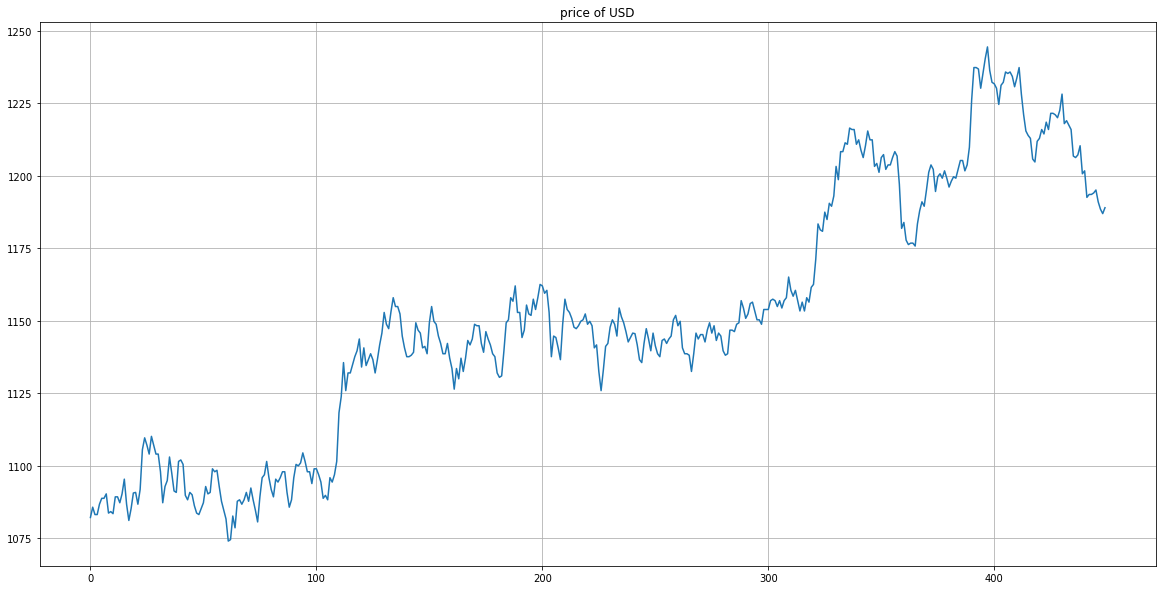

In [2]:
pay = pd.read_csv("USD.csv")

plt.figure(figsize=(20, 10))
plt.plot(range(len(price)), pay['현찰사실때'])
plt.title('price of USD')
plt.grid()
plt.show()

## (5) 분석 결과 도출<br>
### [1] LSTM을 통한 데이터 예측 및 오차 계산<br>

오픈소스를 이용하여 USD(미국)의 2018.01.01-2019.10.31 간의 데이터를 학습시켜 마지막 40일의 데이터를 예측한다.<br>
이때, LSTM은 50일 간의 Window를 만들어 그 다음 하루를 예측하며, Window를 생성할때 예측한 데이터는 사용하지 않고 실제 데이터 값만을 이용한다.<br>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime
from pandas import DataFrame

Using TensorFlow backend.


In [4]:
# Create Windows
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(price) - sequence_length):
    result.append(price[index: index + sequence_length])

# Normalize Data

normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)
result = np.array(normalized_data)
print(result)

[[ 0.          0.00328987  0.00093336 ...  0.00093336  0.00281857
   0.00469453]
 [ 0.         -0.00234878 -0.00234878 ... -0.00046976  0.00140006
   0.00655816]
 [ 0.          0.          0.00329603 ...  0.00375766  0.00892791
   0.00658283]
 ...
 [ 0.          0.00328138 -0.00328138 ... -0.03732878 -0.03650641
  -0.0397878 ]
 [ 0.         -0.00654131 -0.00981196 ... -0.03965767 -0.04292832
  -0.04496946]
 [ 0.         -0.00329219 -0.00370472 ... -0.0366266  -0.03868118
  -0.03991879]]


In [5]:
# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((359, 50, 1), (40, 50, 1))

In [6]:
# Build a model
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(65, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 65)                43160     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 66        
Total params: 84,026
Trainable params: 84,026
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Train
history = model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 359 samples, validate on 40 samples
Epoch 1/20
359/359 [==============================] - 42s 116ms/step - loss: 3.0830e-04 - val_loss: 2.4297e-04
Epoch 2/20
359/359 [==============================] - 14s 39ms/step - loss: 1.2871e-04 - val_loss: 1.3344e-04
Epoch 3/20
359/359 [==============================] - 14s 39ms/step - loss: 1.2096e-04 - val_loss: 1.7190e-04
Epoch 4/20
359/359 [==============================] - 13s 35ms/step - loss: 1.0173e-04 - val_loss: 9.7854e-05
Epoch 5/20
359/359 [==============================] - 25s 69ms/step - loss: 8.9940e-05 - val_loss: 5.1800e-05
Epoch 6/20
359/359 [==============================] - 15s 42ms/step - loss: 5.8311e-05 - val_loss: 2.3417e-04
Epoch 7/20
359/359 [==============================] - 14s 38ms/step - loss: 6.7614e-05 - val_loss: 1.1649e-04
Epoch 8/20
359/359 [==============================] - 19s 52ms/step - loss: 6.3150e-05 -

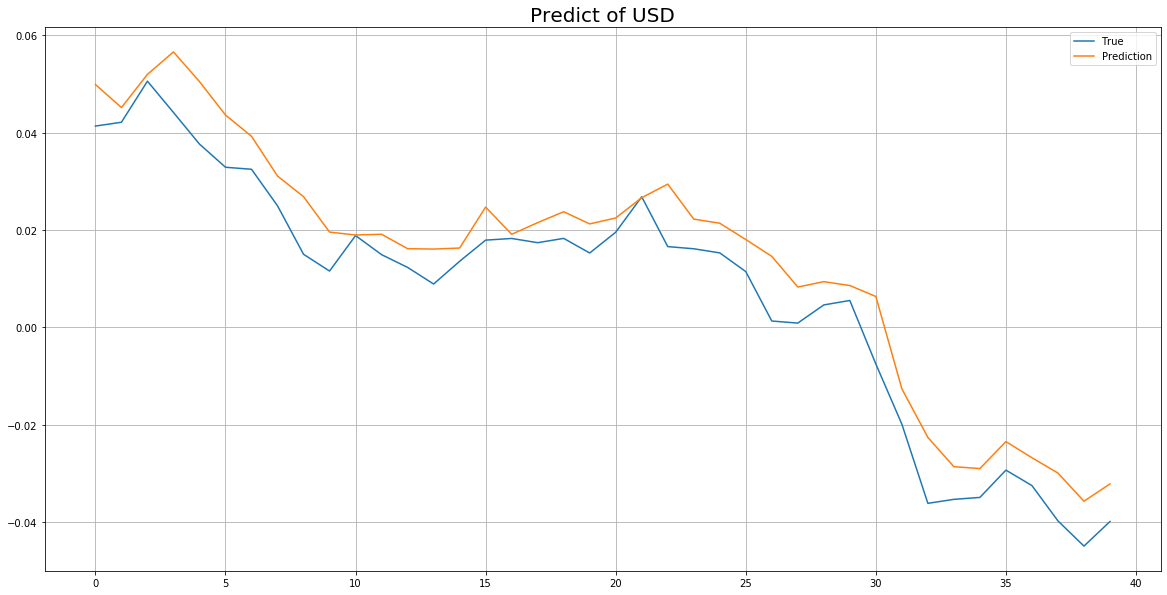

In [8]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
plt.grid()
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title("Predict of USD", size = 20)
ax.legend()
plt.show()

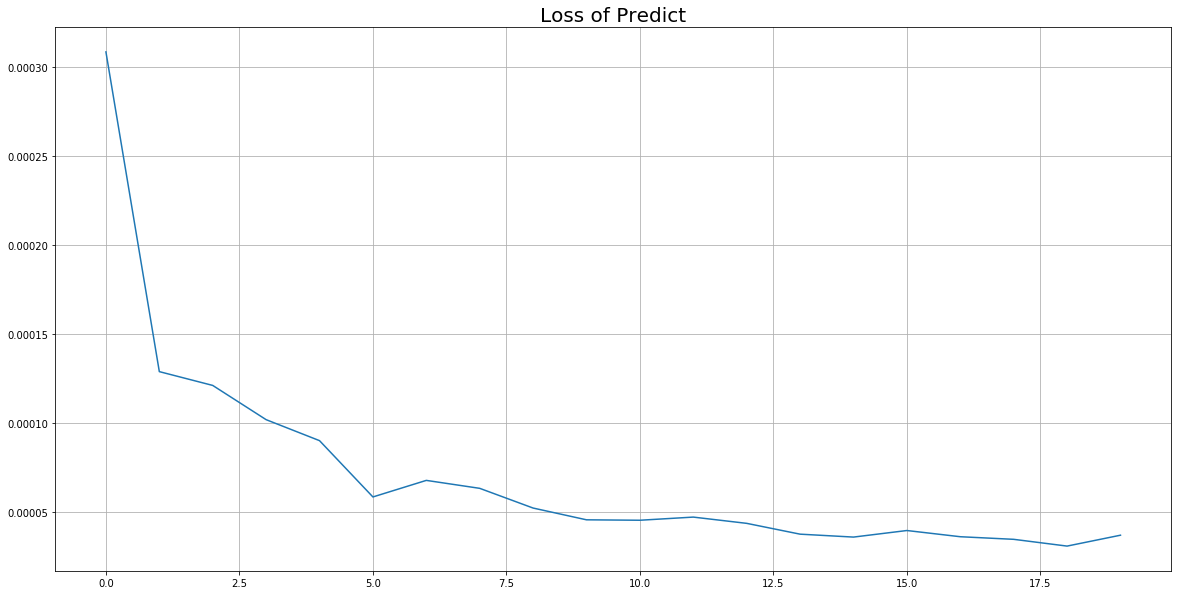

In [9]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(history.history["loss"])
plt.title("Loss of Predict", size = 20)
plt.grid()
plt.show()

LSTM 을 통해 이전의 데이터를 이용하여 USD(미국)의 환율을 예측해본 결과, 위의 그래프에서 볼 수 있듯이 nomalized predict data의 오차범위는 약 0.00030, 그 때의 상대오차는 약 7.5*10^(-3)로 낮게 나타났다.<br>
또한, 횟수를 거듭할수록 오차가 줄어드는 것을 관찰할 수 있다.<br>
<br>
따라서 LSTM을 통해 환율을 예측하는 것이 유의미하다고 판단하였고, 기존의 데이터만을 이용하여 바로 다음 하루의 환율을 예측하는 오픈소스 코드를 수정하여, 예측한 데이터 값을 포함한 전체 데이터로 다음 40일의 환율을 예측하는 코드를 작성해보고자 한다.<br>
<br>

### [2] LSTM을 통해 미래의 환율 예측

[1]에서 사용한 코드를 수정하여 2018.01.01-2019.10.31 의 데이터를 통해 이후 28일의 환율을 예측한다.

In [12]:
pay = data['현찰사실때'][400:].values
pay_list = list(pay)
nomalize = []
pre_result = []


for i in range(0, 28):
    
    p = pay_list[0]
    
    for j in pay_list:
        nomalize.append([j/p - 1])
    
    result1 = np.array([nomalize])

    pred = model.predict(result1)
    pre_result.append(pred[0][0])
    
    real_pay = p*(pred[0][0]+1)
    pay_list.pop(0)
    pay_list.append(real_pay)
    
    del nomalize[0:]
    del result1

print(pre_result)
print(len(pre_result))

[-0.030052437, -0.024499947, -0.015870601, -0.016775269, -0.013667861, -0.01285645, -0.009315679, -0.0069239615, -0.0032697627, 0.0016575777, 0.0013477579, 0.0007762909, 0.009996714, 0.01733007, 0.023162954, 0.025520306, 0.027363973, 0.033991672, 0.035401374, 0.030265458, 0.030323902, 0.028838094, 0.031072656, 0.028758276, 0.03174115, 0.028107597, 0.029019132, 0.030222902]
28


Text(0.5, 1.0, 'Predict of USD')

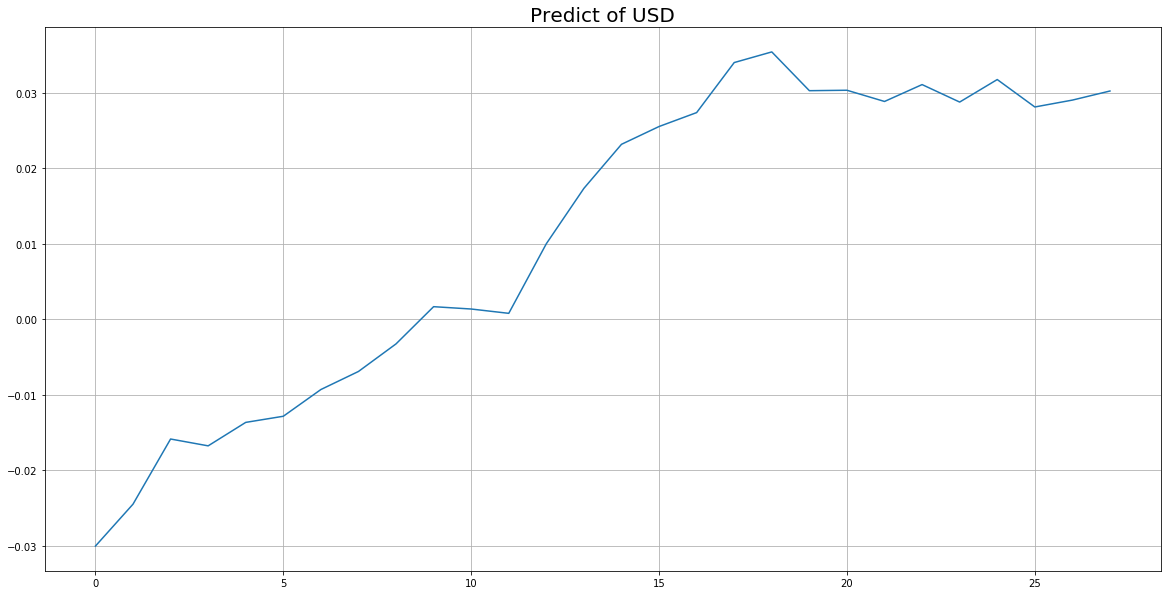

In [13]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(pre_result)
plt.grid()
plt.title("Predict of USD", size = 20)

같은 방법으로 위에 언급한 12개국의 2019.10.31 이후 40일의 데이터를 예측한 결과는 다음과 같다.

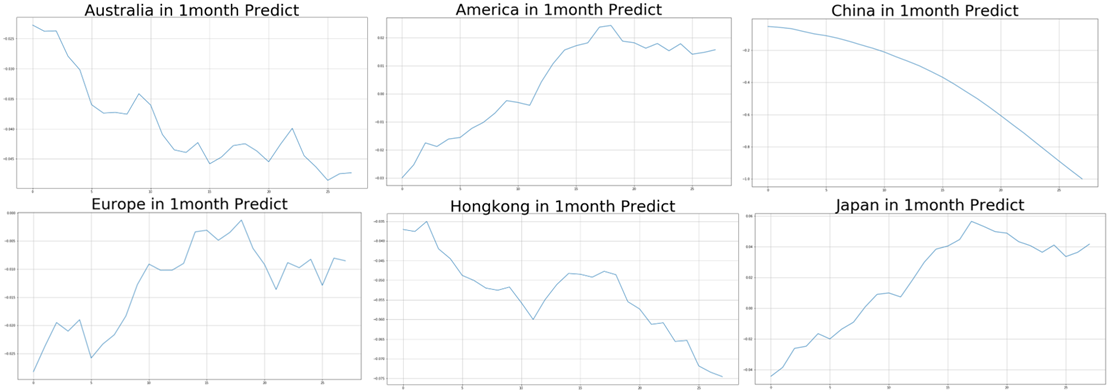

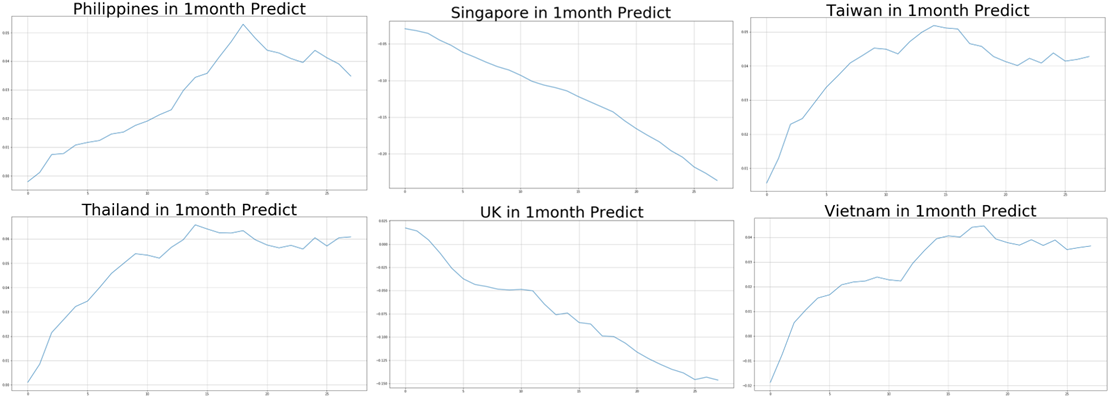

### [3] 미래 예측 데이터와 실제 데이터 비교<br>
예측한 데이터의 기간인 2019.10.31일로 부터 24일의 환율이 집계된 시점에서, 예측한 데이터가 실제 데이터와 얼마나 유사한지 비교하고자 한다.<br>
비교는 위와 마찬가지로 USD(미국)의 데이터를 바탕으로 하였다.<br>

In [14]:
# 2019.10.31 이후 실제 데이터
data1 = pd.read_csv("USD_true.csv")
price1 = data1['현찰사실때'].values
print(price1)
len(price1)

[1187.42 1180.8  1176.23 1178.77 1176.23 1177.75 1185.89 1183.86 1189.96
 1190.98 1187.42 1185.89 1186.91 1190.98 1196.07 1198.61 1197.08 1198.1
 1198.1  1199.63 1200.65 1205.73 1210.82 1213.87]


24

### Normalized data

In [27]:
# Normalize
nor_price1 = []
for i in range(24):
    nor_price1.append(price1[i]/price[400+i]-1)

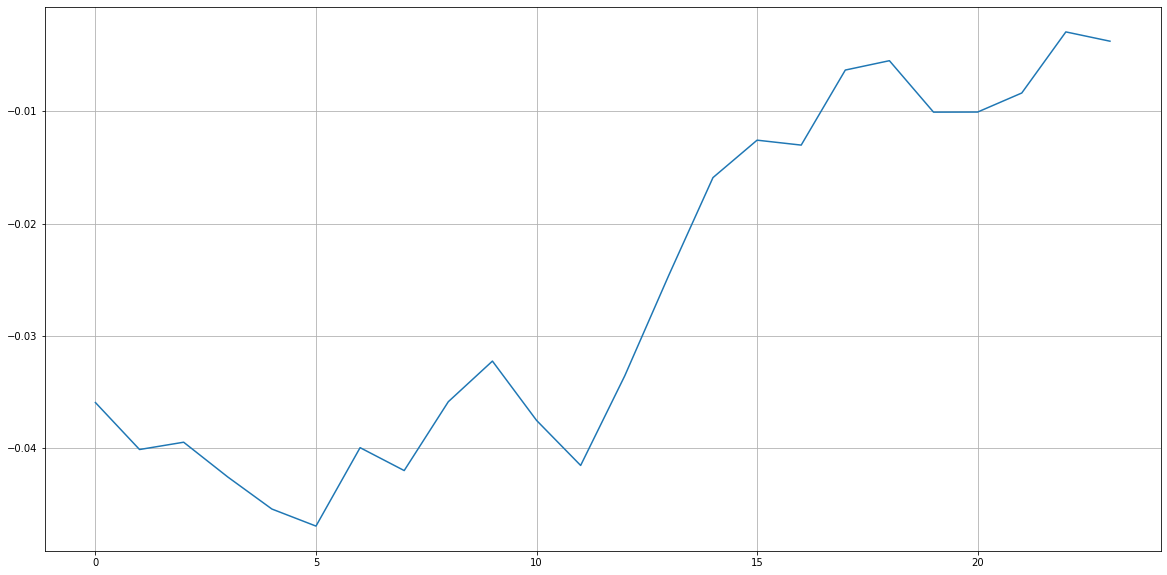

In [28]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(nor_price1)
plt.grid()

### Error graph

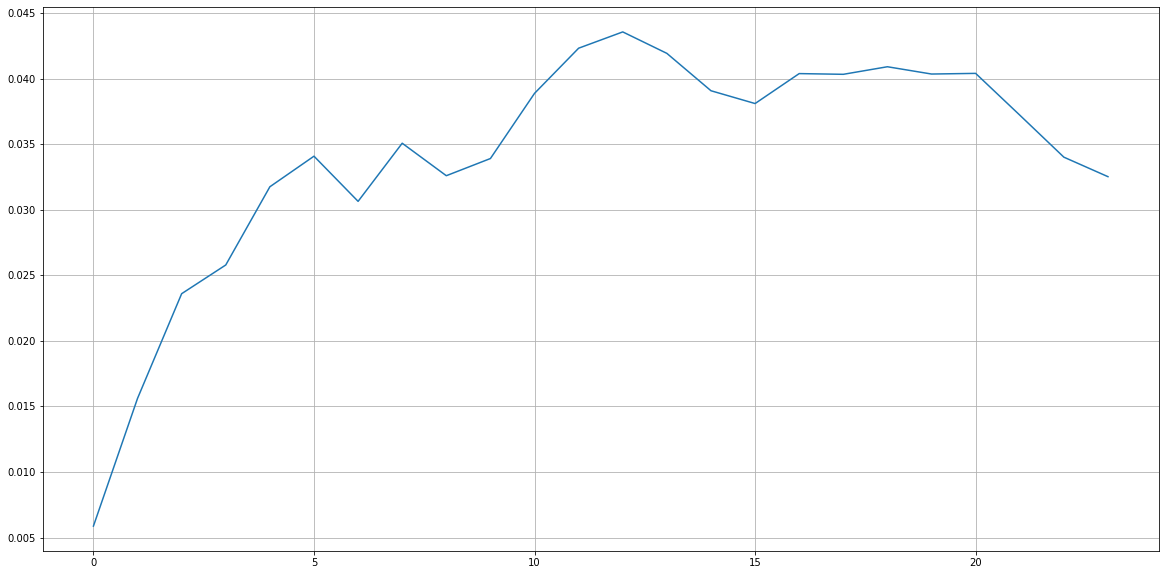

In [30]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
error = []
for i in range(24):
    error.append(abs(nor_price1[i]-pre_result[i]))
plt.plot(error)
plt.grid()

## (6) 결론<br>

기존의 LSTM을 수정하여 USD(미국)의 환율을 예측한 결과, 실제 환율의 추세와 유사하게 나타나는 것을 알 수 있었다.<br>
하지만, [1]기존의 방식을 이용했을때 오차범위가 약 0.00030로 나타났음에 반해 [3]에서는 오차범위가 약 0.045로 크게 증가하였다.<br>
또한, 실제 데이터로 예측한 그래프 초반부에서는 오차가 작게 나타나며, Window에 예측한 데이터가 많이 사용되는 후반부로 갈수록 오차가 증가하는 추세를 보인다.<br>
<br>
이렇게 오차가 크게 나타난 이유에 대해 다음과 같이 분석하였다.<br>
<br>
1. 수정된 LSTM의 알고리즘<br>
기존의 LSTM은 전체 데이터를 학습시킨 뒤, 50개의 실제 데이터만을 이용하여 다음 하루의 환율을 예측하였다. 하지만 미래 40일의 데이터를 예측하기 위해 예측한 데이터를 포함한 50개의 데이터로 그 이후의 데이터를 예측하였는데, 이때 오차의 누적으로 인해 오차가 커졌을 것이다.<br>
<br>
2. 국제 정세의 미반영<br>
이번 프로젝트에서 환율을 예측할 때, 이전의 환율 데이터를 넣는 것 외에 다른 작업을 하지 않았기 때문에 국제 정세를 반영하지 못했을 것이다. 따라서 최근 미중 무역전쟁, 한일 지소미아 등 국제적인 이슈로 환율이 크게 변화하였는데, 이로 인한 변동을 반영하지 못하였을 가능성이 크다.<br>
<br>
따라서 더 정확한 예측 환율을 제공하기 위해서는 환율에 영향을 미칠 수 있는 정치적 요인을 반영하는 함수를 추가하여 전반적인 오차의 크기를 줄일 필요가 있다고 결론을 내렸다.

## (7) 참고문헌<br>

1. 민형기, 파이썬으로 데이터 주무르기, 비제이퍼블릭(2017)<br>
2. https://github.com/kairess/stock_crypto_price_prediction<br>
3. https://www.youtube.com/watch?v=sG_WeGbZ9A4<br>